# Initial analysis

## Set up

In [1]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Import data

In [2]:
bucket = "courtman-ermesuspensionandfluvialrate-rawdata"
file_name = "raw.csv"

s3 = boto3.client("s3") 
obj = s3.get_object(Bucket= bucket, Key= file_name) 

erme_df = pd.read_csv(obj["Body"])

In [3]:
erme_df.head()

Date  Time     DoW    PTCODE                         NAME  \
0  07/04/1975  1315  Monday  70920142  RIVER ERME AT STOWFORD WEIR   
1  07/04/1975  1315  Monday  70920142  RIVER ERME AT STOWFORD WEIR   
2  07/04/1975  1315  Monday  70920142  RIVER ERME AT STOWFORD WEIR   
3  07/04/1975  1315  Monday  70920142  RIVER ERME AT STOWFORD WEIR   
4  07/04/1975  1315  Monday  70920142  RIVER ERME AT STOWFORD WEIR   

           PTTYPE_DESC           NGR LAST_SAMPLED MATERIAL  \
0  FRESHWATER - RIVERS  SX6377257053    07-Dec-18     2AZZ   
1  FRESHWATER - RIVERS  SX6377257053    07-Dec-18     2AZZ   
2  FRESHWATER - RIVERS  SX6377257053    07-Dec-18     2AZZ   
3  FRESHWATER - RIVERS  SX6377257053    07-Dec-18     2AZZ   
4  FRESHWATER - RIVERS  SX6377257053    07-Dec-18     2AZZ   

                       MATL_DESC                          DETNAME  \
0  RIVER / RUNNING SURFACE WATER                               pH   
1  RIVER / RUNNING SURFACE WATER             Conductivity at 20 C   
2  RIVER / RUNNING SURFACE WATER             Temperature of Water   
3  RIVER / RUNNING SURFACE WATER                      BOD : 5 Day   
4  RIVER / RUNNING SURFACE WATER  Permanganate Value N/80 4 Hours   

                      DETUNITS UNIT_SHORT QUAL   RESULT INTERPRETATION  \
0                     PH UNITS    PHUNITS  NaN   7.1000            NaN   
1  MICROSIEMENS PER CENTIMETRE      uS/cm  NaN  55.6686            NaN   
2                      CELSIUS        CEL  NaN   5.5000            NaN   
3          MILLIGRAM PER LITRE       mg/l  NaN   1.1000            NaN   
4          MILLIGRAM PER LITRE       mg/l  NaN   1.0000            NaN   

  TEXT_RESULT SAMPLER_NOTES  
0         NaN           NaN  
1         NaN           NaN  
2         NaN           NaN  
3         NaN           NaN  
4         NaN           NaN

What measurements are in the dataset?

In [4]:
erme_df["DETNAME"].unique()

array(['pH', 'Conductivity at 20 C', 'Temperature of Water',
       'BOD : 5 Day', 'Permanganate Value N/80 4 Hours',
       'Ammoniacal Nitrogen as N', 'Nitrate as N',
       'Ammonia un-ionised as N', 'Solids, Suspended at 105 C',
       'Hardness, Total as CaCO3', 'Alkalinity to pH 4.5 as CaCO3',
       'Chloride', 'Orthophosphate, reactive as P', 'Sodium, Dissolved',
       'Potassium, Dissolved', 'Magnesium, Dissolved',
       'Calcium, Dissolved', 'Oxygen, Dissolved, % Saturation',
       'Oxygen, Dissolved as O2', 'Lead', 'Lead, Dissolved', 'Cadmium',
       'Chromium', 'Zinc, Dissolved', 'Manganese', 'Iron', 'Copper',
       'Zinc', 'Manganese, Dissolved', 'Iron, Dissolved', 'Nickel',
       'Silica, reactive as SiO2', 'Carbon, Organic, Total as C :- {TOC}',
       'Solids, non-volatile at 500 C', 'Flow, instantaneous',
       'BOD : 5 Day ATU', 'Nitrogen, Total Oxidised as N', 'Nitrite as N',
       'Sulphate as SO4', 'Time', 'Sodium', 'Potassium', 'Magnesium',
       'Calcium

And how many are there?

In [5]:
len(erme_df["DETNAME"].unique())

212

## Consolidate data

Let's create a new dataframe for our consolidated data, and add each new measurement per instance iteratively.

In [6]:
consolidated_df = pd.DataFrame(columns = erme_df["DETNAME"].unique())
consolidated_df.insert(0, "Date", [])
consolidated_df.insert(1, "Name", [])

In [7]:
date = ""
name = ""

for index, row in erme_df.iterrows():
    new_date = erme_df["Date"].iloc[index]
    new_name = erme_df["NAME"].iloc[index]
    
    measurement = erme_df["DETNAME"].iloc[index]
    result = erme_df["RESULT"].iloc[index]
    
    row_index = consolidated_df.index[(consolidated_df["Date"]==new_date) & 
                                      (consolidated_df["Name"]==new_name)].tolist()
    
    if len(row_index) == 0:
        consolidated_df = consolidated_df.append([{"Date":new_date, 
                                                   "Name":new_name,
                                                   measurement:result}], 
                                                 ignore_index=True)
        date = new_date
        name = new_name

    else:   
        consolidated_df.at[row_index[0],measurement] = result

/home/megan/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [8]:
consolidated_df.head()

Date                         Name   pH  Conductivity at 20 C  \
0  07/04/1975  RIVER ERME AT STOWFORD WEIR  7.1               55.6686   
1  21/05/1975  RIVER ERME AT STOWFORD WEIR  7.2               57.4938   
2  22/07/1975  RIVER ERME AT STOWFORD WEIR  6.3               53.8434   
3  12/11/1975  RIVER ERME AT STOWFORD WEIR  6.6               52.9308   
4  19/05/1976  RIVER ERME AT STOWFORD WEIR  7.0               57.4938   

   Temperature of Water  BOD : 5 Day  Permanganate Value N/80 4 Hours  \
0                   5.5          1.1                              1.0   
1                  13.0          1.0                              0.8   
2                  15.5          0.5                              2.6   
3                   8.0          1.3                              1.0   
4                  10.0          1.1                              1.8   

   Ammoniacal Nitrogen as N  Nitrate as N  Ammonia un-ionised as N  ...  \
0                      0.03          0.45                      0.0  ...   
1                      0.04          0.44                      0.0  ...   
2                      0.02          0.27                      0.0  ...   
3                      0.01          0.18                      0.0  ...   
4                      0.03          0.46                      0.0  ...   

   Mitochondrial Marker : Human  Mitochondrial Marker : Canine  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN                            NaN   

   Mitochondrial Marker : Avian  Microbial Source Tracking  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   

   Bacteroidetes Marker : Ruminant  Bacteroidetes Marker : All  \
0                              NaN                         NaN   
1                              NaN                         NaN   
2                              NaN                         NaN   
3                              NaN                         NaN   
4                              NaN                         NaN   

   Bacteroides HF183 primer  Preparation: DNA  Salinity : In Situ  \
0                       NaN               NaN                 NaN   
1                       NaN               NaN                 NaN   
2                       NaN               NaN                 NaN   
3                       NaN               NaN                 NaN   
4                       NaN               NaN                 NaN   

   Conductivity at 25 C  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  

[5 rows x 214 columns]

Let's check that the number of entries matches the unique combinations of date and site:

In [9]:
consolidated_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 214 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Date                                                516 non-null    object 
 1   Name                                                516 non-null    object 
 2   pH                                                  442 non-null    float64
 3   Conductivity at 20 C                                272 non-null    float64
 4   Temperature of Water                                460 non-null    float64
 5   BOD : 5 Day                                         10 non-null     float64
 6   Permanganate Value N/80 4 Hours                     46 non-null     float64
 7   Ammoniacal Nitrogen as N                            460 non-null    float64
 8   Nitrate as N                                        440 non-null    float64
 9 

In [10]:
erme_df.groupby(["Date", "NAME"]).ngroups

516

In [11]:
consolidated_df["Date"] = pd.to_datetime(consolidated_df["Date"], format="%d/%m/%Y")

## Initial visualisation

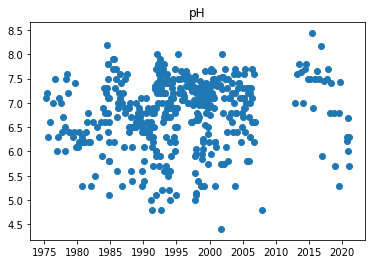

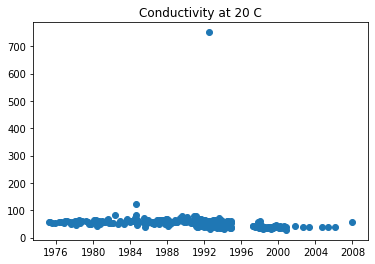

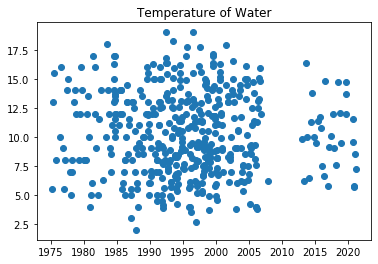

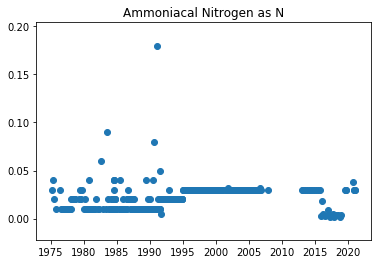

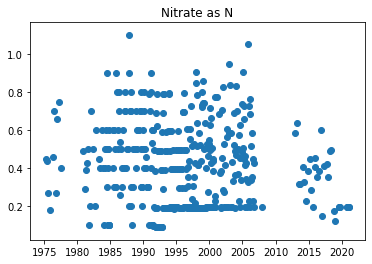

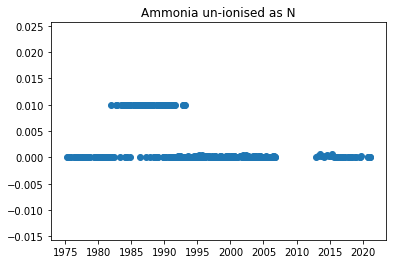

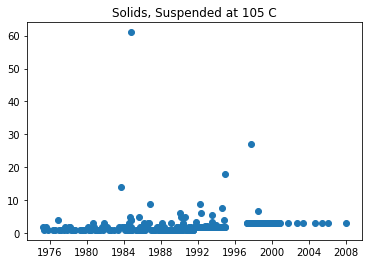

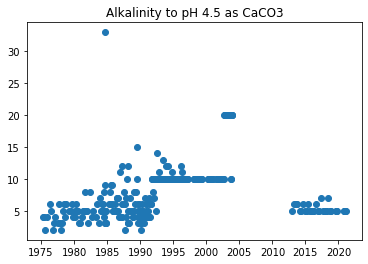

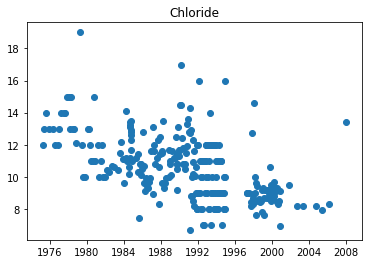

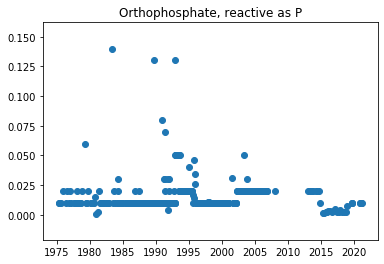

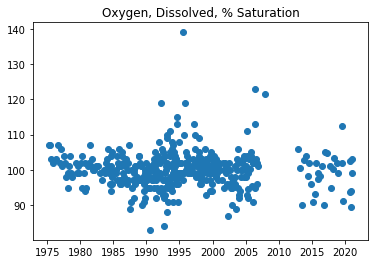

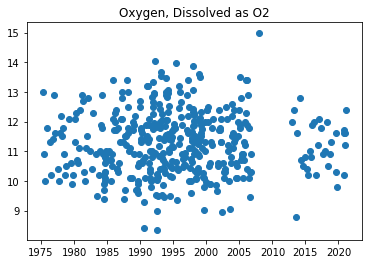

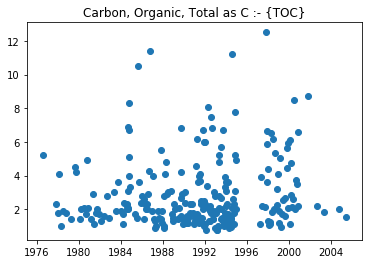

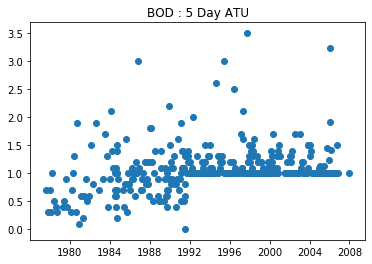

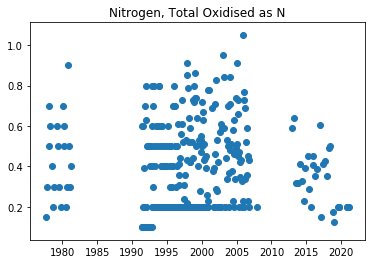

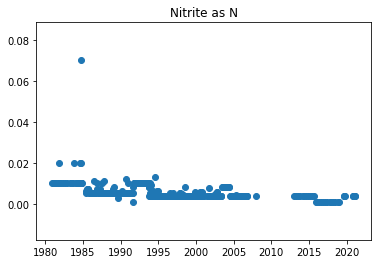

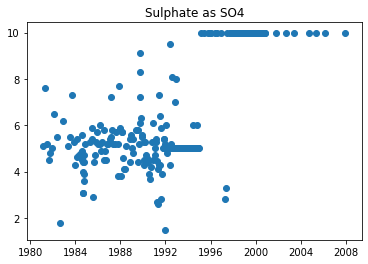

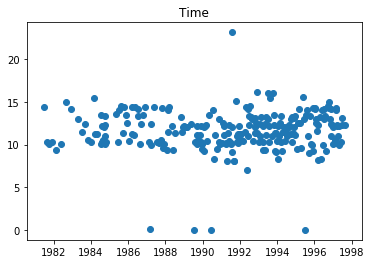

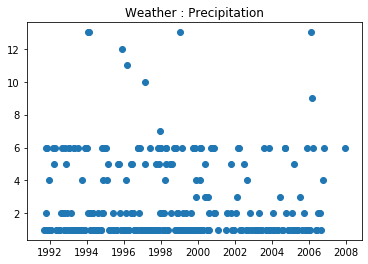

In [12]:
for column_name in erme_df["DETNAME"].unique():
    if consolidated_df[column_name].count() > 250:
        plt.scatter(consolidated_df["Date"],
                    consolidated_df[column_name])
        plt.title(column_name)
        plt.show()

## Split into site dataframes

### Stowford Weir

In [13]:
stowford_weir = consolidated_df[consolidated_df["Name"]=="RIVER ERME AT STOWFORD WEIR"]
stowford_weir = stowford_weir.reset_index()
stowford_weir = stowford_weir.drop(["Name", "index"], axis = 1)
stowford_weir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Columns: 213 entries, Date to Conductivity at 25 C
dtypes: datetime64[ns](1), float64(212)
memory usage: 642.5 KB


In [14]:
stowford_weir.head()

Date   pH  Conductivity at 20 C  Temperature of Water  BOD : 5 Day  \
0 1975-04-07  7.1               55.6686                   5.5          1.1   
1 1975-05-21  7.2               57.4938                  13.0          1.0   
2 1975-07-22  6.3               53.8434                  15.5          0.5   
3 1975-11-12  6.6               52.9308                   8.0          1.3   
4 1976-05-19  7.0               57.4938                  10.0          1.1   

   Permanganate Value N/80 4 Hours  Ammoniacal Nitrogen as N  Nitrate as N  \
0                              1.0                      0.03          0.45   
1                              0.8                      0.04          0.44   
2                              2.6                      0.02          0.27   
3                              1.0                      0.01          0.18   
4                              1.8                      0.03          0.46   

   Ammonia un-ionised as N  Solids, Suspended at 105 C  ...  \
0                      0.0                         2.0  ...   
1                      0.0                         1.0  ...   
2                      0.0                         2.0  ...   
3                      0.0                         1.0  ...   
4                      0.0                         1.0  ...   

   Mitochondrial Marker : Human  Mitochondrial Marker : Canine  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN                            NaN   

   Mitochondrial Marker : Avian  Microbial Source Tracking  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   

   Bacteroidetes Marker : Ruminant  Bacteroidetes Marker : All  \
0                              NaN                         NaN   
1                              NaN                         NaN   
2                              NaN                         NaN   
3                              NaN                         NaN   
4                              NaN                         NaN   

   Bacteroides HF183 primer  Preparation: DNA  Salinity : In Situ  \
0                       NaN               NaN                 NaN   
1                       NaN               NaN                 NaN   
2                       NaN               NaN                 NaN   
3                       NaN               NaN                 NaN   
4                       NaN               NaN                 NaN   

   Conductivity at 25 C  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  

[5 rows x 213 columns]

In [15]:
stowford_weir.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 213 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   Date                                                386 non-null    datetime64[ns]
 1   pH                                                  337 non-null    float64       
 2   Conductivity at 20 C                                176 non-null    float64       
 3   Temperature of Water                                337 non-null    float64       
 4   BOD : 5 Day                                         10 non-null     float64       
 5   Permanganate Value N/80 4 Hours                     46 non-null     float64       
 6   Ammoniacal Nitrogen as N                            337 non-null    float64       
 7   Nitrate as N                                        318 non-null    float64       
 8   Ammonia u

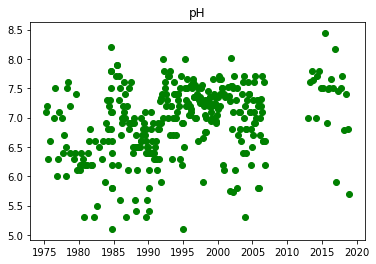

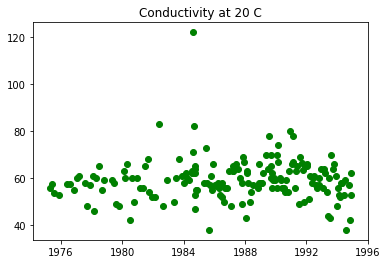

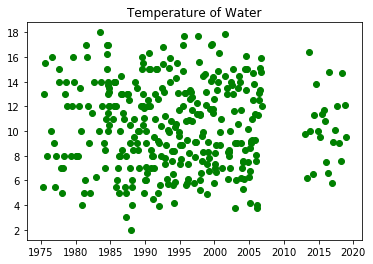

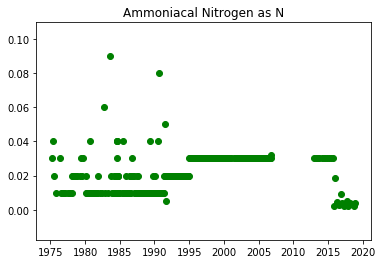

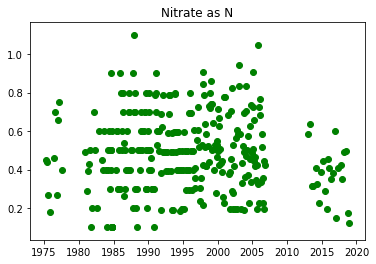

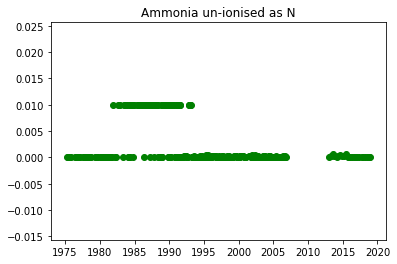

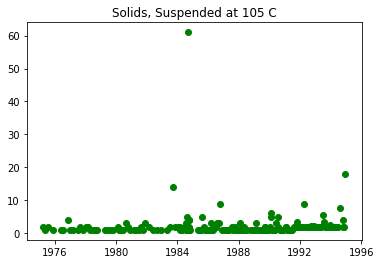

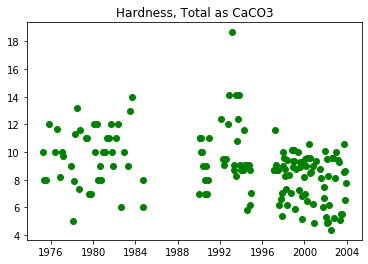

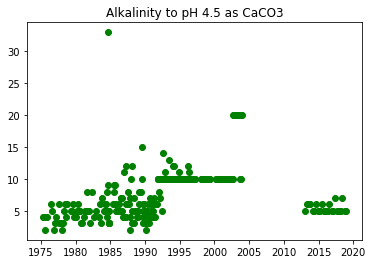

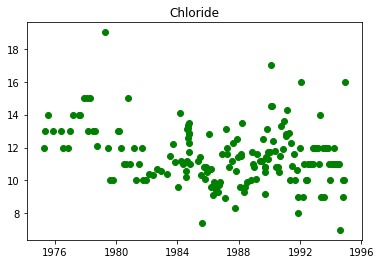

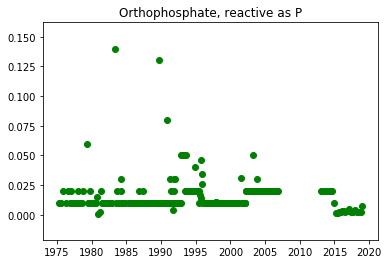

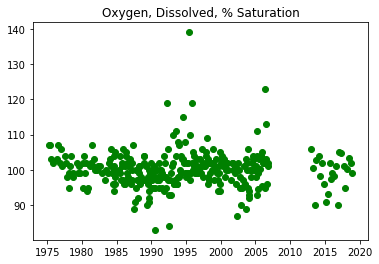

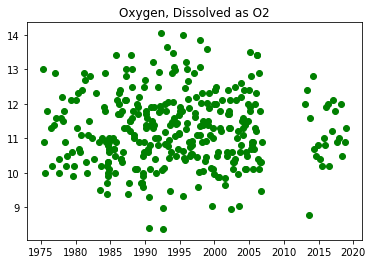

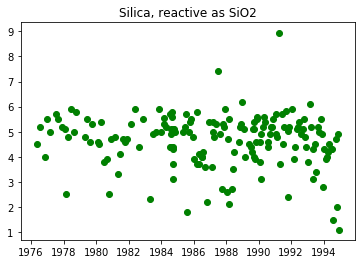

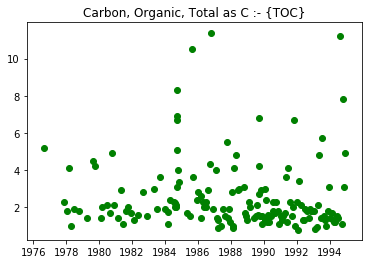

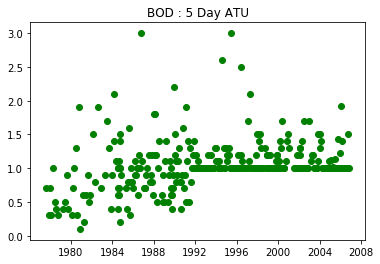

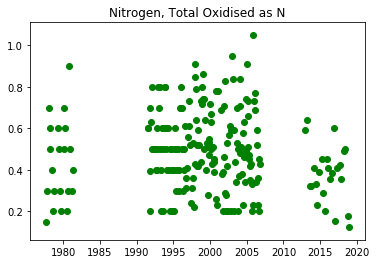

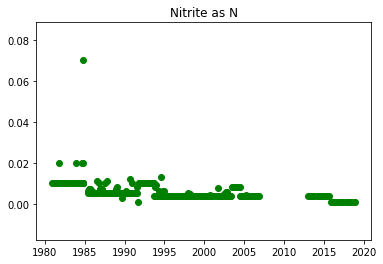

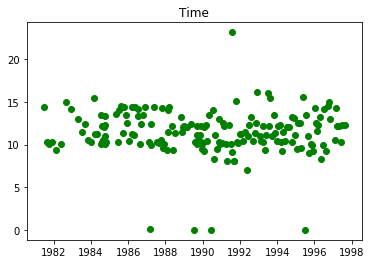

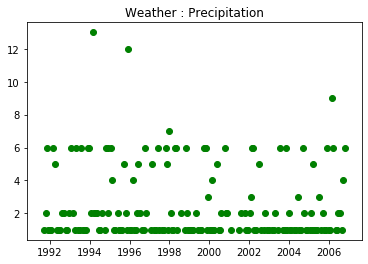

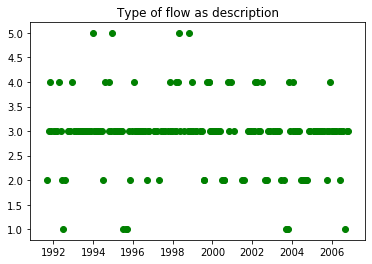

In [16]:
for column_name in erme_df["DETNAME"].unique():
    if stowford_weir[column_name].count() > 150:
        plt.scatter(stowford_weir["Date"],
                    stowford_weir[column_name],
                    color="green")
        plt.title(column_name)
        plt.show()

### Harford Moor

In [17]:
harford_moor = consolidated_df[consolidated_df["Name"]=="RIVER ERME HARFORD MOOR (RIVER ABSTRACTION POINT)"]
harford_moor = harford_moor.reset_index()
harford_moor = harford_moor.drop(["Name", "index"], axis = 1)
harford_moor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Columns: 213 entries, Date to Conductivity at 25 C
dtypes: datetime64[ns](1), float64(212)
memory usage: 216.5 KB


In [18]:
harford_moor.head()

Date   pH  Conductivity at 20 C  Temperature of Water  BOD : 5 Day  \
0 1991-02-15  5.0                  41.0                   5.0          NaN   
1 1991-04-12  4.8                  39.0                   9.0          NaN   
2 1991-05-14  6.5                  39.0                  13.0          NaN   
3 1991-06-10  6.2                  44.0                  11.0          NaN   
4 1991-07-02  5.7                  48.7                  12.5          NaN   

   Permanganate Value N/80 4 Hours  Ammoniacal Nitrogen as N  Nitrate as N  \
0                              NaN                      0.18         0.400   
1                              NaN                      0.01         0.100   
2                              NaN                      0.01         0.100   
3                              NaN                      0.01         0.100   
4                              NaN                      0.01         0.095   

   Ammonia un-ionised as N  Solids, Suspended at 105 C  ...  \
0                      0.0                         2.0  ...   
1                      0.0                         1.0  ...   
2                      0.0                         1.0  ...   
3                      0.0                         1.0  ...   
4                      0.0                         1.0  ...   

   Mitochondrial Marker : Human  Mitochondrial Marker : Canine  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN                            NaN   

   Mitochondrial Marker : Avian  Microbial Source Tracking  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   

   Bacteroidetes Marker : Ruminant  Bacteroidetes Marker : All  \
0                              NaN                         NaN   
1                              NaN                         NaN   
2                              NaN                         NaN   
3                              NaN                         NaN   
4                              NaN                         NaN   

   Bacteroides HF183 primer  Preparation: DNA  Salinity : In Situ  \
0                       NaN               NaN                 NaN   
1                       NaN               NaN                 NaN   
2                       NaN               NaN                 NaN   
3                       NaN               NaN                 NaN   
4                       NaN               NaN                 NaN   

   Conductivity at 25 C  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  

[5 rows x 213 columns]

In [19]:
harford_moor.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 213 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   Date                                                130 non-null    datetime64[ns]
 1   pH                                                  105 non-null    float64       
 2   Conductivity at 20 C                                96 non-null     float64       
 3   Temperature of Water                                123 non-null    float64       
 4   BOD : 5 Day                                         0 non-null      float64       
 5   Permanganate Value N/80 4 Hours                     0 non-null      float64       
 6   Ammoniacal Nitrogen as N                            123 non-null    float64       
 7   Nitrate as N                                        122 non-null    float64       
 8   Ammonia u

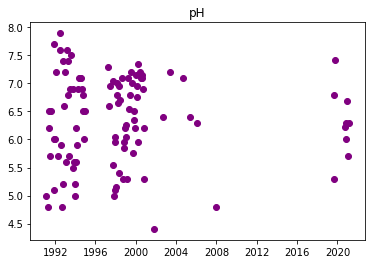

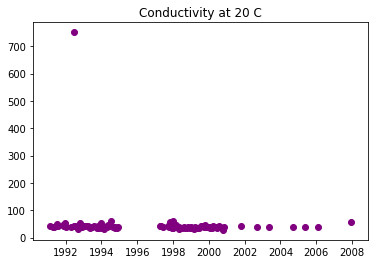

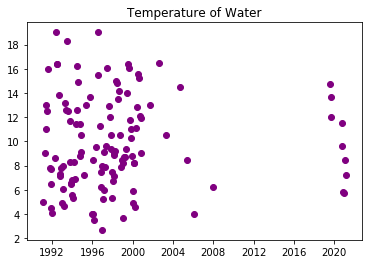

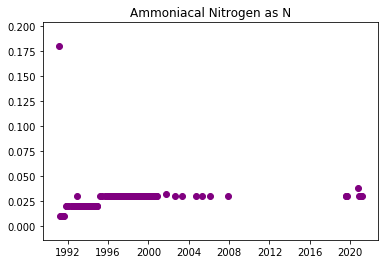

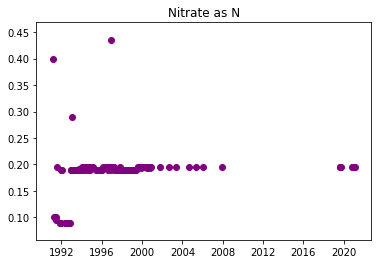

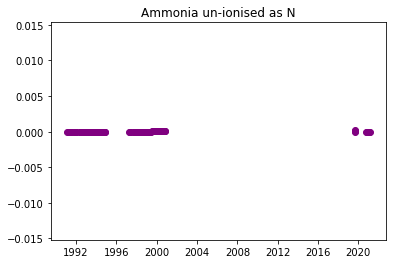

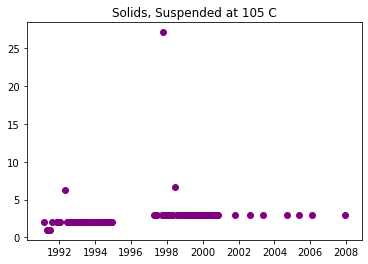

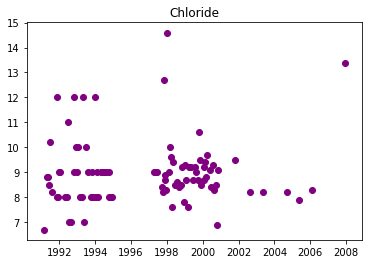

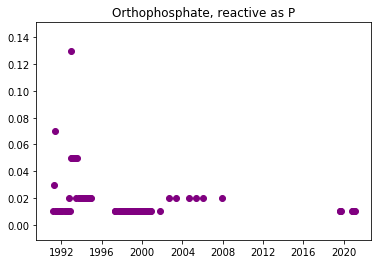

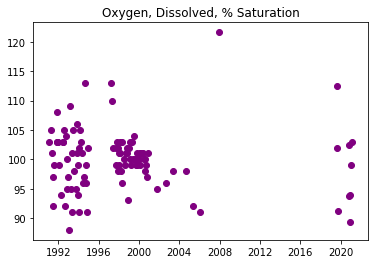

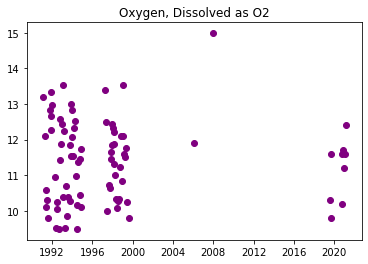

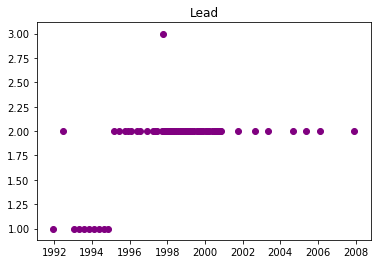

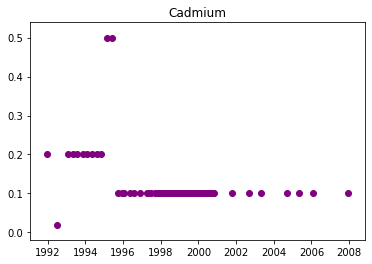

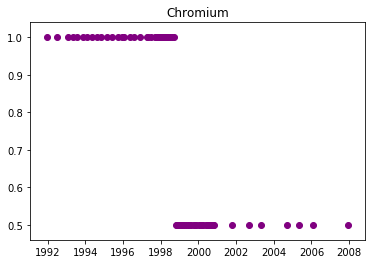

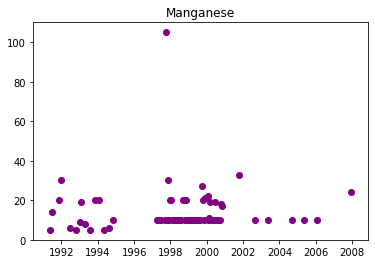

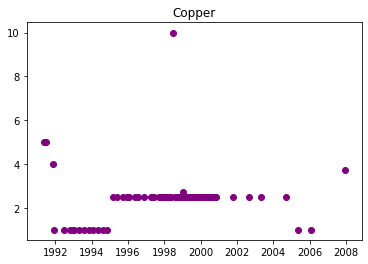

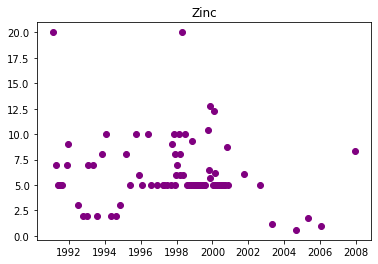

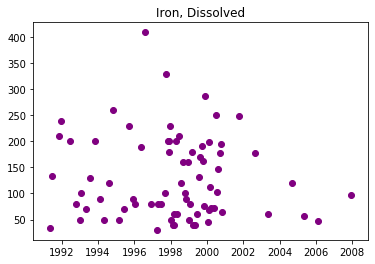

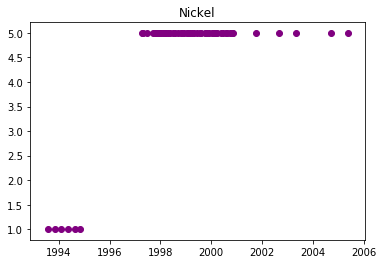

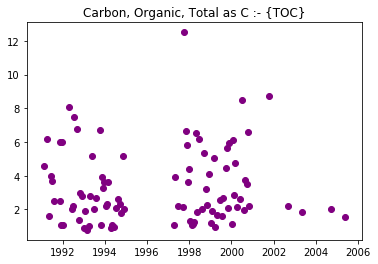

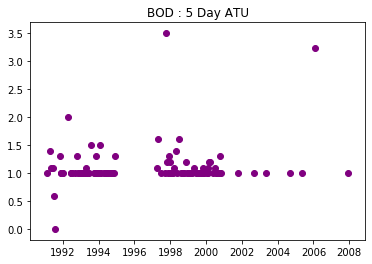

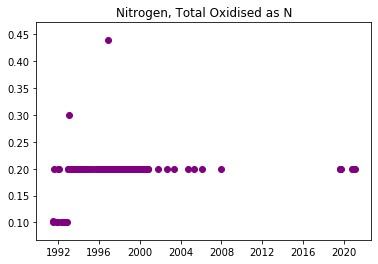

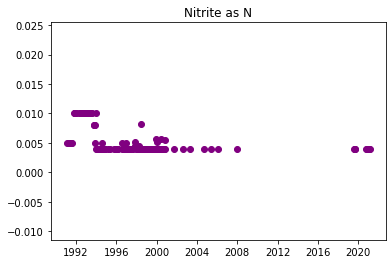

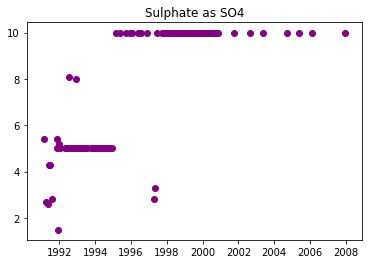

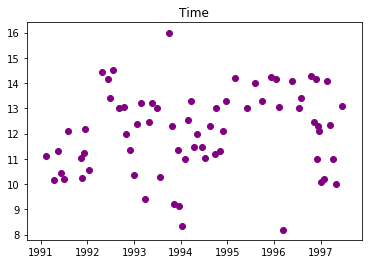

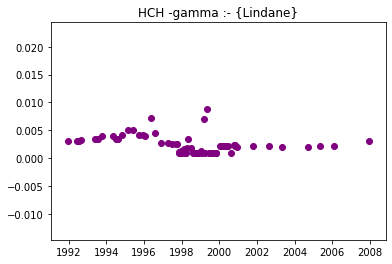

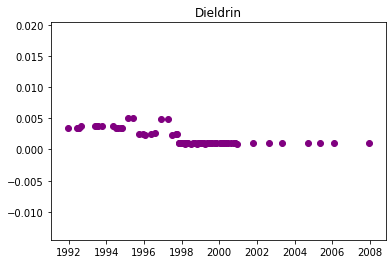

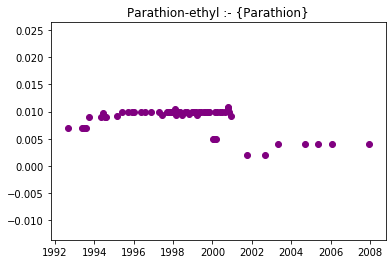

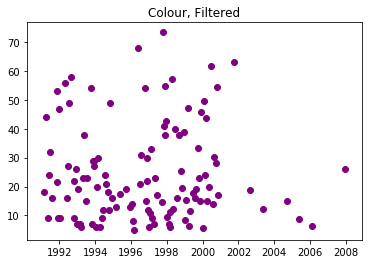

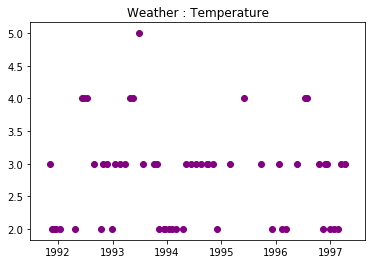

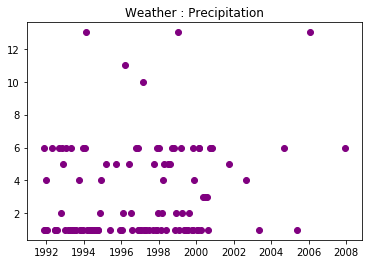

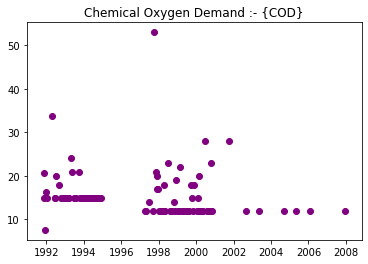

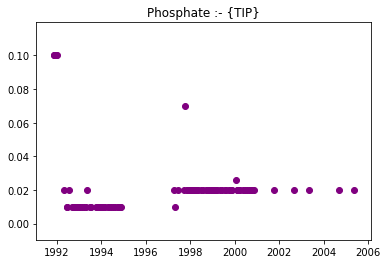

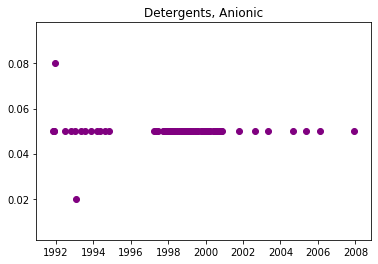

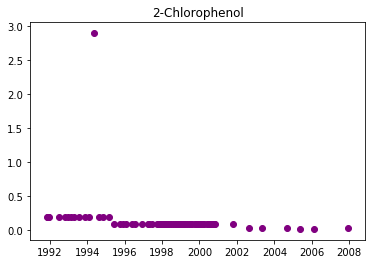

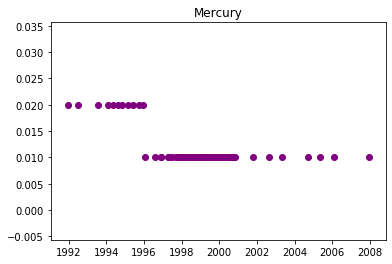

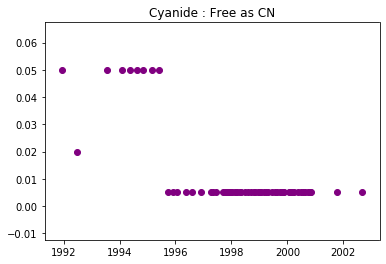

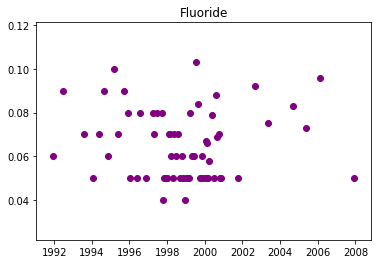

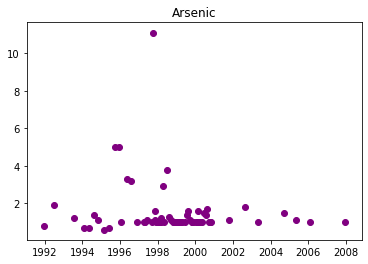

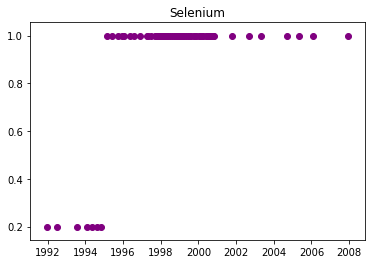

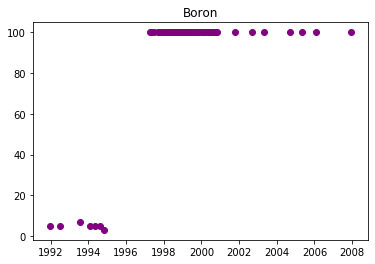

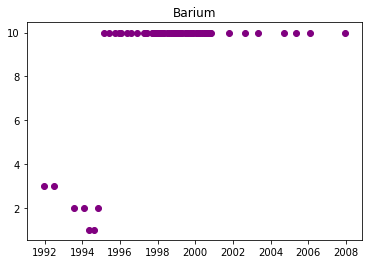

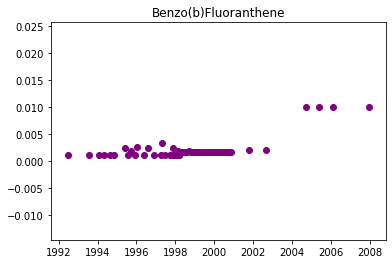

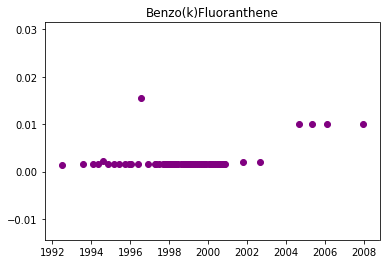

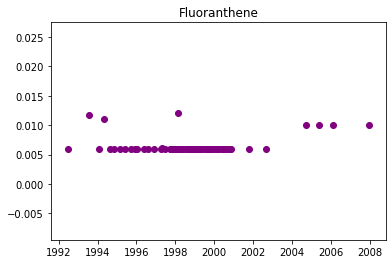

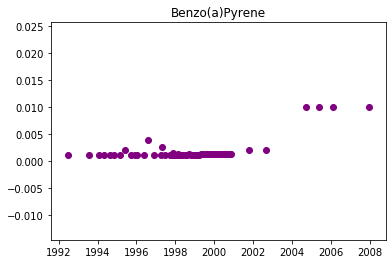

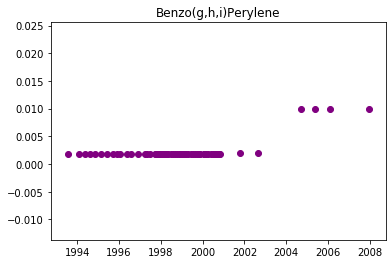

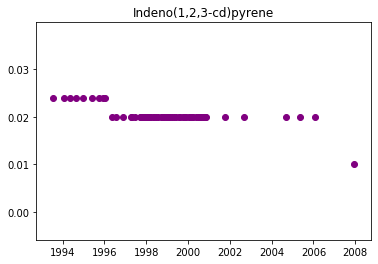

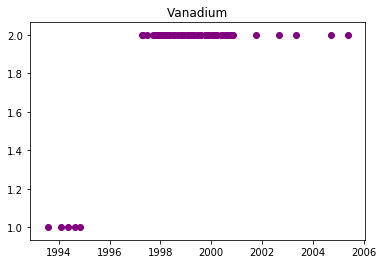

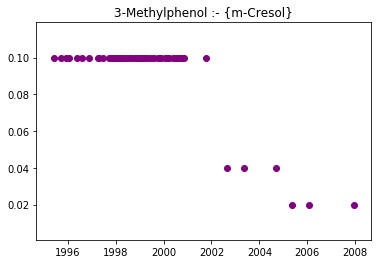

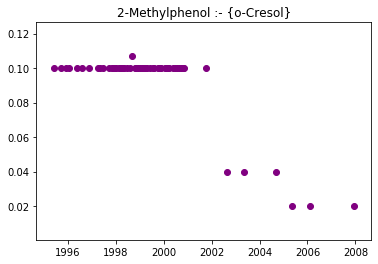

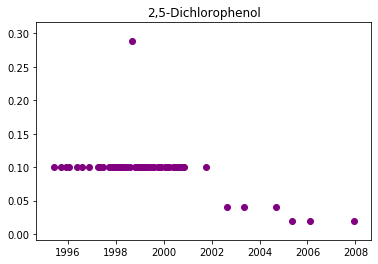

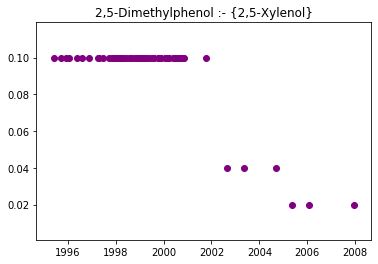

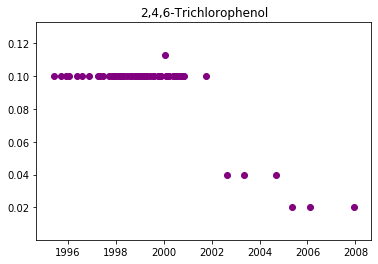

In [20]:
for column_name in erme_df["DETNAME"].unique():
    if harford_moor[column_name].count() > 50:
        plt.scatter(harford_moor["Date"],
                    harford_moor[column_name],
                    color="purple")
        plt.title(column_name)
        plt.show()

## Save processed dataframes as CSVs

In [21]:
stowford_weir.to_csv("s3://courtman-ermesuspensionandfluvialrate-dev-processeddata-megan/stowford_weir.csv", index=False)
harford_moor.to_csv("s3://courtman-ermesuspensionandfluvialrate-dev-processeddata-megan/harford_moor.csv", index=False)

## Questions arising

- Why are there so few records for most measurements?
- Why is there missing data for Stowford Weir circa 2010?
- Why do a lot of Harford Moor measurements end in 2008?